In [12]:
import pandas as pd
import numpy as np

In [13]:
earn_df = pd.read_stata("../data/earn_and_edu.dta")
earn_df.head()

edu_cats = {
    "bachelor's degree": 1,
    "4 years of college": 1, # Assumption that 4 years of college equates to a
                             # bachelors degree - needed in order to get approx
                             # college information from years prior to the
                             # "bachelor's degree" classification.

    "12th grade, diploma unclear": 0,
    "high school diploma or equivalent": 0
}

# Apply critera to data
earn_df = earn_df[
    (earn_df["educ"].isin(edu_cats.keys())) &
    (earn_df["sex"] == "male") &
    (earn_df["inctot"] > 0) &
    (earn_df["inctot"] < 99999997)
]

earn_df["educ"] = earn_df["educ"].map(edu_cats).astype(int)

earn_df = pd.DataFrame(earn_df.to_numpy(), columns=earn_df.columns)
earn_df.sort_values(["year", "inctot"], inplace=True)

earn_df.head()

,year,serial,month,hwtfinl,cpsid,asecflag,hflag,asecwth,pernum,wtfinl,cpsidp,asecwt,sex,educ,inctot,incwage,incbus,incfarm
653,1962,1865,march,NaN,NaN,NaN,NaN,1551.2,1,NaN,NaN,1551.2,male,0,1,0,1,0
1215,1962,4962,march,NaN,NaN,NaN,NaN,1376.36,1,NaN,NaN,1376.36,male,0,1,0,0,1
2659,1962,11306,march,NaN,NaN,NaN,NaN,1673.56,1,NaN,NaN,1673.56,male,0,1,0,1,0
2682,1962,11386,march,NaN,NaN,NaN,NaN,1531.62,1,NaN,NaN,1531.62,male,0,1,0,1,0
3249,1962,14114,march,NaN,NaN,NaN,NaN,1709.19,1,NaN,NaN,1709.19,male,0,1,0,1,0


In [14]:
# Add quantile labels for grouping
earn_df["decile"] = pd.Series(np.zeros(len(earn_df)))

# Weighted deciling is a royal pain in the ass.
for year in earn_df["year"].unique():
    subset = earn_df[earn_df["year"] == year]
    decile = pd.Series(np.zeros(len(subset)) + 0.1)
    decile.index = subset.index

    cumsum = subset["asecwt"].cumsum()
    for d in range(9):
        cutoff = subset["asecwt"].sum() * (d + 1) * 0.1
        decile.loc[subset["asecwt"][cumsum >= cutoff].index] += 0.1

    earn_df["decile"] = earn_df["decile"].add(decile, fill_value = 0)

earn_df["decile"] *= 10.001
earn_df["decile"] = earn_df["decile"].astype(int)

earn_df["decile"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [15]:
earn_df["inctot"] = earn_df["inctot"].astype(float)
earn_df["asecwt"] = earn_df["asecwt"].astype(float)

all_groups = earn_df.groupby(
    by=["year"]
)

dec_groups = earn_df.groupby(
    by=["year", "decile"]
)

edu_groups = earn_df.groupby(
    by=["year", "educ"]
)

<AxesSubplot:xlabel='year'>

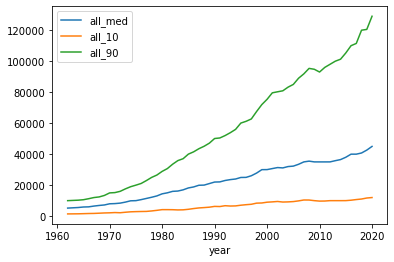

In [16]:
df = pd.DataFrame()

df["col_count"]  = edu_groups.count()["serial"].loc[:, 1] / all_groups.count()["serial"]
df["all_10"]    = dec_groups.max()["inctot"].loc[:, 1]
df["all_90"]    = dec_groups.min()["inctot"].loc[:, 10]
df["all_med"]  =  dec_groups.max()["inctot"].loc[:, 5]

df["top_share"] = dec_groups.sum()["inctot"].loc[:, 10]  / all_groups.sum()["inctot"]

df[["all_med", "all_10", "all_90"]].plot()

In [17]:
earn_df = pd.read_stata("../data/earn_and_edu.dta")
earn_df.head()

edu_cats = {
    "bachelor's degree": 1,
    "4 years of college": 1, # Assumption that 4 years of college equates to a
                             # bachelors degree - needed in order to get approx
                             # college information from years prior to the
                             # "bachelor's degree" classification.

    "12th grade, diploma unclear": 0,
    "high school diploma or equivalent": 0
}

# Apply critera to data
earn_df = earn_df[
    (earn_df["educ"].isin(edu_cats.keys())) &
    (earn_df["sex"] == "male") &
    (earn_df["inctot"] > 0) &
    (earn_df["inctot"] < 99999997)
]

earn_df["educ"] = earn_df["educ"].map(edu_cats).astype(int)

earn_df = pd.DataFrame(earn_df.to_numpy(), columns=earn_df.columns)
earn_df.sort_values(["year", "inctot"], inplace=True)

earn_df.head()


<AxesSubplot:xlabel='year'>

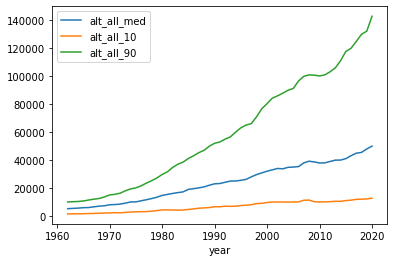

In [32]:
edu_groups = earn_df.groupby(
    by=["year", "educ"]
)

all_groups = earn_df.groupby(
    by=["year"]
)

earn_df["asecwt"] = earn_df["asecwt"].astype(float)

baseline = 1962
col_rates = edu_groups.sum()["asecwt"].loc[:,1] / all_groups.sum()["asecwt"]
alt_rates = col_rates + (col_rates.index - baseline) * 0.0025
positive = alt_rates / col_rates
negative = (1 - alt_rates) / (1 - col_rates)

earn_df["modifier"] = earn_df.apply(
    axis = 1,
    func = lambda x: positive.loc[x["year"]] if x["educ"] == 1 else negative.loc[x["year"]]
)

earn_df["modifier"]
earn_df["mod_asecwt"] = earn_df["asecwt"] * earn_df["modifier"]

In [ ]:

# Add quantile labels for grouping
earn_df["decile"] = pd.Series(np.zeros(len(earn_df)))

# Weighted deciling is a royal pain in the ass.
for year in earn_df["year"].unique():
    subset = earn_df[earn_df["year"] == year]
    decile = pd.Series(np.zeros(len(subset)) + 0.1)
    decile.index = subset.index

    cumsum = subset["mod_asecwt"].cumsum()
    for d in range(9):
        cutoff = subset["mod_asecwt"].sum() * (d + 1) * 0.1
        decile.loc[subset["mod_asecwt"][cumsum >= cutoff].index] += 0.1

    earn_df["decile"] = earn_df["decile"].add(decile, fill_value = 0)

earn_df["decile"] *= 10.001
earn_df["decile"] = earn_df["decile"].astype(int)

earn_df["decile"].unique()

earn_df["inctot"] = earn_df["inctot"].astype(float)
earn_df["mod_asecwt"] = earn_df["mod_asecwt"].astype(float)

all_groups = earn_df.groupby(
    by=["year"]
)

dec_groups = earn_df.groupby(
    by=["year", "decile"]
)

edu_groups = earn_df.groupby(
    by=["year", "educ"]
)

df["alt_col_count"]  = edu_groups.sum()["mod_asecwt"].loc[:, 1] / all_groups.sum()["mod_asecwt"]
df["alt_all_10"]    = dec_groups.max()["inctot"].loc[:, 1]
df["alt_all_90"]    = dec_groups.min()["inctot"].loc[:, 10]
df["alt_all_med"]  =  dec_groups.max()["inctot"].loc[:, 5]

df["alt_top_share"] = dec_groups.sum()["inctot"].loc[:, 10]  / all_groups.sum()["inctot"]

df[["alt_all_med", "alt_all_10", "alt_all_90"]].plot()

<AxesSubplot:xlabel='year'>

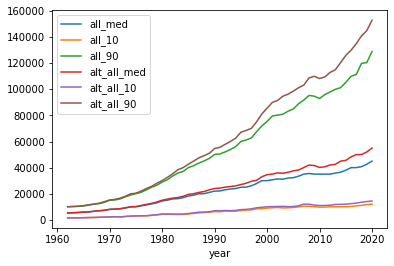

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

df[[
    "all_med", "all_10", "all_90",
    "alt_all_med", "alt_all_10", "alt_all_90"
]].plot()

plt.savefig("analysis.pdf")